In [1]:
import pandas as pd
import numpy as np
import warnings 
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def setup_sns_english_theme():
    """
    Configure Seaborn and Matplotlib for clean English-language visualizations.
    This includes white background, clear gridlines, and suitable font sizes for notebooks or presentations.
    """

    # Use Seaborn default settings (colors, styles, etc.)
    sns.set()

    # Set plot style: white background with grid
    sns.set_style("whitegrid")  # Options: 'darkgrid', 'whitegrid', 'dark', 'white', 'ticks'

    # Set plot context: adjusts font size and element scaling
    sns.set_context("talk")  # Options: 'paper', 'notebook', 'talk', 'poster'

    # Optional: set font family for Matplotlib (English sans-serif)
    plt.rcParams['font.family'] = 'DejaVu Sans'  # This is default, can change to 'Arial' or 'Helvetica'

    # Ensure minus signs display correctly on axes
    plt.rcParams['axes.unicode_minus'] = True

# Call this function at the top of your notebook
setup_sns_english_theme()

In [2]:
def reduce_mem_usage(df, verbose=True):
    """
    Reduce memory usage of a DataFrame by downcasting numeric columns
    and converting object columns to category where appropriate
    Datetime columns are preseved(skip)

    Paremeters:
    - df (pd.DataFrame): The input DataFrame to optimize
    - verbose (bool): If True, prints memory usage info
                      If False, just execute the operation

    Returns:
    - df (pd.DataFrame): Optimized DataFrame
    """
    # Calculate memory usage before optimization
    # 'deep=True' ensures object-type columns (e.g. strings) are fully measured
    # Divide by 1024^2 to convert bytes to megabytes
    start_mem = df.memory_usage(deep=True).sum() / 1024**2

    # Iterate through each columns in the DataFrame
    for col in df.columns:
        col_type = df[col].dtype

        # Skip datetime columns to avoid corrupting temporal data
        if pd.api.types.is_datetime64_any_dtype(col_type):
            continue

        # If the column is numeric(integer or float)
        elif pd.api.types.is_numeric_dtype(col_type):
            c_min = df[col].min()
            c_max = df[col].max()

            # If the column is an integer type
            if pd.api.types.is_integer_dtype(col_type):
                # Try downcasting to the smallest possible integer type
                if c_min >= np.iinfo(np.int8).min and c_max <= np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min >= np.iinfo(np.int16).min and c_max <= np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min >= np.iinfo(np.int32).min and c_max <= np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                else:
                    df[col] = df[col].astype(np.int64)

            # If the column is an float type
            else:
                # Try downcasting to float16, float32, or keep as float64
                if c_min >= np.finfo(np.float16).min and c_max <= np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min >= np.finfo(np.float32).min and c_max <= np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                #elif c_min >= np.finfo(np.float64).min and c_max <= np.finfo(np.float64).max:
                else:
                    df[col] = df[col].astype(np.float64)
        # If the column is an object type
        elif pd.api.types.is_object_dtype(col_type):
            num_unique = df[col].nunique()
            num_total = len(df[col])
            # if the unique ratio is below 50%, convert to category for memory
            if num_unique / num_total < 0.5:
                df[col] = df[col].astype('category')

        # Other types are not modified

    # Calculate memory usage after optimization
    end_mem = df.memory_usage(deep=True).sum() / 1024**2

    if verbose:
        # Print summary of memory usage before and after optimization
        print(f"Memory usage before optimization: {start_mem:.2f} MB")
        print(f"Memory usage after optimization: {end_mem:.2f} MB")
        print(f"Reduced by: {100 * (start_mem - end_mem) / start_mem:.1f}%")

    return df

In [3]:
data_os = pd.read_csv('data_train_os.csv')

In [4]:
test_os = pd.read_csv('data_test_os.csv')

In [5]:
data_os.head()

,loanAmnt,term,interestRate,installment,grade,subGrade,employmentTitle,employmentLength,homeOwnership,annualIncome,...,n7,n8,n9,n10,n11,n12,n13,n14,issueDateDT,isDefault
0,35000.0,5,19.52,917.97,5,21,320.0,2.0,2,110000.0,...,4.0,12.0,2.0,7.0,0.0,0.0,0.0,2.0,2587,1
1,18000.0,5,18.49,461.90,4,16,219843.0,5.0,0,46000.0,...,NaN,NaN,NaN,13.0,NaN,NaN,NaN,NaN,1888,0
2,12000.0,5,16.99,298.17,4,17,31698.0,8.0,0,74000.0,...,4.0,5.0,3.0,11.0,0.0,0.0,0.0,4.0,3044,0
3,3000.0,3,12.99,101.07,3,11,54.0,NaN,1,29000.0,...,10.0,15.0,7.0,12.0,0.0,0.0,0.0,4.0,3196,0
4,2050.0,3,7.69,63.95,1,3,180083.0,9.0,0,35000.0,...,10.0,18.0,3.0,12.0,0.0,0.0,0.0,3.0,2679,0


In [6]:
data_os = reduce_mem_usage(data_os)
test_os = reduce_mem_usage(test_os)

Memory usage before optimization: 223.87 MB
Memory usage after optimization: 53.53 MB
Reduced by: 76.1%
Memory usage before optimization: 68.66 MB
Memory usage after optimization: 16.59 MB
Reduced by: 75.8%


In [7]:
y_os = data_os['isDefault']
X_os = data_os.drop(['isDefault'], axis=1)
print(y_os.shape, X_os.shape, test_os.shape)

(637893,) (637893, 45) (200000, 45)


In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier
import numpy as np

def evaluate_model_cv(model, X, y, n_splits=5, seed=2020, model_name="model"):
    """
    Perform K-Fold cross-validation and compute AUC for each fold.

    Parameters:
    - model: sklearn / xgb / cat model instance or None for LGB/XGB
    - X: pd.DataFrame
    - y: pd.Series
    - n_splits: int, number of folds
    - seed: int, random seed
    - model_name: str, for display and internal control

    Returns:
    - list of AUC scores
    """
    print(f"\n🚀 Running {model_name} with {n_splits}-fold CV...")
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    scores = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
        print(f"\n===== Fold {fold + 1} / {n_splits} =====")
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        if model_name == "XGBoost":
            dtrain = xgb.DMatrix(X_train, label=y_train)
            dval = xgb.DMatrix(X_val, label=y_val)
            params = {
                'objective': 'binary:logistic',
                'eval_metric': 'auc',
                'verbosity': 0,
                'seed': seed
            }
            xgb_model = xgb.train(params, dtrain, num_boost_round=100,
                                  evals=[(dval, "valid")],
                                  early_stopping_rounds=20,
                                  verbose_eval=False)
            val_preds = xgb_model.predict(dval)

        elif model_name == "CatBoost":
            cat_model = CatBoostClassifier(verbose=0, random_state=seed)
            cat_model.fit(X_train, y_train)
            val_preds = cat_model.predict_proba(X_val)[:, 1]

        elif model_name == "LightGBM":
            train_set = lgb.Dataset(X_train, label=y_train)
            valid_set = lgb.Dataset(X_val, label=y_val)
            params = {
                'objective': 'binary',
                'metric': 'auc',
                'verbosity': -1,
                'seed': seed
            }
            lgb_model = lgb.train(params, train_set, valid_sets=[valid_set],
                                  num_boost_round=100,
                                  callbacks=[lgb.early_stopping(stopping_rounds=200),
                                             lgb.log_evaluation(period=200)])
            val_preds = lgb_model.predict(X_val, num_iteration=lgb_model.best_iteration)

        else:
            model.fit(X_train, y_train)
            val_preds = model.predict_proba(X_val)[:, 1]

        auc = roc_auc_score(y_val, val_preds)
        scores.append(auc)
        print(f"AUC: {auc:.4f}")

    print(f"\n📊 {model_name} CV AUCs: {[f'{s:.4f}' for s in scores]}")
    print(f"Mean AUC: {np.mean(scores):.4f} | Std: {np.std(scores):.4f}")
    return scores

# ==== Individual Model Runners ====

def run_logistic_regression_baseline(X, y):
    model = LogisticRegression()
    return evaluate_model_cv(model, X, y, model_name="Logistic Regression")

def run_random_forest_baseline(X, y):
    model = RandomForestClassifier()
    return evaluate_model_cv(model, X, y, model_name="Random Forest")

def run_xgboost_baseline(X, y):
    return evaluate_model_cv(None, X, y, model_name="XGBoost")

def run_catboost_baseline(X, y):
    return evaluate_model_cv(None, X, y, model_name="CatBoost")

def run_lightgbm_baseline(X, y):
    return evaluate_model_cv(None, X, y, model_name="LightGBM")

In [15]:
X_os.isnull().sum()

loanAmnt              0
term                  0
interestRate          0
installment           0
grade                 0
subGrade              0
employmentTitle       0
employmentLength      0
homeOwnership         0
annualIncome          0
verificationStatus    0
purpose               0
postCode              0
regionCode            0
dti                   0
delinquency_2years    0
ficoRangeLow          0
ficoRangeHigh         0
openAcc               0
pubRec                0
pubRecBankruptcies    0
revolBal              0
revolUtil             0
totalAcc              0
initialListStatus     0
applicationType       0
earliesCreditLine     0
title                 0
policyCode            0
n0                    0
n1                    0
n2                    0
n3                    0
n4                    0
n5                    0
n6                    0
n7                    0
n8                    0
n9                    0
n10                   0
n11                   0
n12             

# A Dataset
## Default Model Evaluation

In [16]:
run_logistic_regression_baseline(X_os, y_os)


🚀 Running Logistic Regression with 5-fold CV...

===== Fold 1 / 5 =====


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


AUC: 0.6134

===== Fold 2 / 5 =====


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


AUC: 0.6142

===== Fold 3 / 5 =====


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


AUC: 0.6110

===== Fold 4 / 5 =====


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


AUC: 0.6220

===== Fold 5 / 5 =====
AUC: 0.6112

📊 Logistic Regression CV AUCs: ['0.6134', '0.6142', '0.6110', '0.6220', '0.6112']
Mean AUC: 0.6144 | Std: 0.0040


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[0.6133644634723319,
 0.6142117565916846,
 0.610984909524426,
 0.6220437223388463,
 0.6112408250298708]

In [17]:
run_random_forest_baseline(X_os, y_os)


🚀 Running Random Forest with 5-fold CV...

===== Fold 1 / 5 =====
AUC: 0.7078

===== Fold 2 / 5 =====
AUC: 0.7065

===== Fold 3 / 5 =====
AUC: 0.7059

===== Fold 4 / 5 =====
AUC: 0.7072

===== Fold 5 / 5 =====
AUC: 0.7075

📊 Random Forest CV AUCs: ['0.7078', '0.7065', '0.7059', '0.7072', '0.7075']
Mean AUC: 0.7070 | Std: 0.0007


[0.7078387585773347,
 0.7064628186147397,
 0.7058730025953706,
 0.7072412612776956,
 0.7075191034648022]

In [18]:
run_xgboost_baseline(X_os, y_os)


🚀 Running XGBoost with 5-fold CV...

===== Fold 1 / 5 =====
AUC: 0.7304

===== Fold 2 / 5 =====
AUC: 0.7241

===== Fold 3 / 5 =====
AUC: 0.7263

===== Fold 4 / 5 =====
AUC: 0.7284

===== Fold 5 / 5 =====
AUC: 0.7286

📊 XGBoost CV AUCs: ['0.7304', '0.7241', '0.7263', '0.7284', '0.7286']
Mean AUC: 0.7276 | Std: 0.0021


[0.7304103231692274,
 0.7241461375325183,
 0.7263273420101468,
 0.7284310409191113,
 0.7285646799617499]

In [19]:
run_catboost_baseline(X_os, y_os)


🚀 Running CatBoost with 5-fold CV...

===== Fold 1 / 5 =====
AUC: 0.7335

===== Fold 2 / 5 =====
AUC: 0.7291

===== Fold 3 / 5 =====
AUC: 0.7298

===== Fold 4 / 5 =====
AUC: 0.7317

===== Fold 5 / 5 =====
AUC: 0.7331

📊 CatBoost CV AUCs: ['0.7335', '0.7291', '0.7298', '0.7317', '0.7331']
Mean AUC: 0.7314 | Std: 0.0017


[0.7334663388738174,
 0.7290843229920964,
 0.7297858388502386,
 0.7317182470835393,
 0.7330911570489045]

In [20]:
run_lightgbm_baseline(X_os, y_os)


🚀 Running LightGBM with 5-fold CV...

===== Fold 1 / 5 =====
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.731003
AUC: 0.7310

===== Fold 2 / 5 =====
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.725711
AUC: 0.7257

===== Fold 3 / 5 =====
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.727443
AUC: 0.7274

===== Fold 4 / 5 =====
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.728326
AUC: 0.7283

===== Fold 5 / 5 =====
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.729857
AUC: 0.7299

📊 LightGBM CV AUCs: ['0.7310', '0.7257', '0.7274', '0.7283', '0.7299']
Mean AUC: 0

[0.7310032328623782,
 0.7257109494342837,
 0.7274425622080052,
 0.7283256234570941,
 0.72985677348525]

# B Dataset
## Default Model Evaluation

In [21]:
run_logistic_regression_baseline(X_cs, y_cs)


🚀 Running Logistic Regression with 5-fold CV...

===== Fold 1 / 5 =====


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


AUC: 0.6952

===== Fold 2 / 5 =====


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


AUC: 0.6885

===== Fold 3 / 5 =====


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


AUC: 0.6926

===== Fold 4 / 5 =====


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


AUC: 0.6909

===== Fold 5 / 5 =====
AUC: 0.6944

📊 Logistic Regression CV AUCs: ['0.6952', '0.6885', '0.6926', '0.6909', '0.6944']
Mean AUC: 0.6923 | Std: 0.0024


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[0.6951741852450302,
 0.6885209885162038,
 0.692645753549912,
 0.6909111743405778,
 0.6944318543916743]

In [22]:
run_random_forest_baseline(X_cs, y_cs)


🚀 Running Random Forest with 5-fold CV...

===== Fold 1 / 5 =====
AUC: 0.6807

===== Fold 2 / 5 =====
AUC: 0.6781

===== Fold 3 / 5 =====
AUC: 0.6788

===== Fold 4 / 5 =====
AUC: 0.6807

===== Fold 5 / 5 =====
AUC: 0.6825

📊 Random Forest CV AUCs: ['0.6807', '0.6781', '0.6788', '0.6807', '0.6825']
Mean AUC: 0.6802 | Std: 0.0016


[0.6807308810756547,
 0.6781265670000058,
 0.6788164635433793,
 0.6807227193849144,
 0.6825043171530892]

In [23]:
run_xgboost_baseline(X_cs, y_cs)


🚀 Running XGBoost with 5-fold CV...

===== Fold 1 / 5 =====
AUC: 0.7091

===== Fold 2 / 5 =====
AUC: 0.7041

===== Fold 3 / 5 =====
AUC: 0.7056

===== Fold 4 / 5 =====
AUC: 0.7060

===== Fold 5 / 5 =====
AUC: 0.7079

📊 XGBoost CV AUCs: ['0.7091', '0.7041', '0.7056', '0.7060', '0.7079']
Mean AUC: 0.7065 | Std: 0.0018


[0.7091295587486148,
 0.7041035134770921,
 0.7056270358634649,
 0.7059712982204631,
 0.7078607403165408]

In [24]:
run_catboost_baseline(X_cs, y_cs)


🚀 Running CatBoost with 5-fold CV...

===== Fold 1 / 5 =====
AUC: 0.7104

===== Fold 2 / 5 =====
AUC: 0.7049

===== Fold 3 / 5 =====
AUC: 0.7069

===== Fold 4 / 5 =====
AUC: 0.7080

===== Fold 5 / 5 =====
AUC: 0.7087

📊 CatBoost CV AUCs: ['0.7104', '0.7049', '0.7069', '0.7080', '0.7087']
Mean AUC: 0.7078 | Std: 0.0018


[0.71043860592748,
 0.7049204891675123,
 0.7069130249207655,
 0.7079614832624366,
 0.7086771290366961]

In [25]:
run_lightgbm_baseline(X_cs, y_cs)


🚀 Running LightGBM with 5-fold CV...

===== Fold 1 / 5 =====
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.709717
AUC: 0.7097

===== Fold 2 / 5 =====
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[94]	valid_0's auc: 0.705009
AUC: 0.7050

===== Fold 3 / 5 =====
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[95]	valid_0's auc: 0.707052
AUC: 0.7071

===== Fold 4 / 5 =====
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[93]	valid_0's auc: 0.706782
AUC: 0.7068

===== Fold 5 / 5 =====
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.708555
AUC: 0.7086

📊 LightGBM CV AUCs: ['0.7097', '0.7050', '0.7071', '0.7068', '0.7086']
Mean AUC: 0.707

[0.709717353186565,
 0.7050094545961152,
 0.70705216058774,
 0.7067820875561882,
 0.7085550295801484]

# 调参

In [32]:
from bayes_opt import BayesianOptimization
import seaborn as sns
from sklearn.model_selection import train_test_split


def bayesian_lgb_optimizer(X, y, init_points=5, n_iter=15, test_size=0.2, random_state=42):
    """
    LightGBM Bayesian optimization with ROC and feature importance visualization.

    Parameters:
    - X: pd.DataFrame, features
    - y: pd.Series or np.array, target labels
    - init_points: int, number of random explorations before optimization
    - n_iter: int, number of iterations for optimization
    - test_size: float, proportion of test split
    - random_state: int, reproducibility

    Returns:
    - best_model: trained LightGBM model
    - best_params: dict, optimal parameters
    """
    
    def lgb_cv(num_leaves, max_depth, bagging_fraction, feature_fraction,
               bagging_freq, min_data_in_leaf, min_child_weight,
               min_split_gain, reg_alpha, reg_lambda):

        params = {
            'boosting_type': 'gbdt',
            'objective': 'binary',
            'metric': 'auc',
            'learning_rate': 0.05,
            'verbose': -1,
            'num_leaves': int(num_leaves),
            'max_depth': int(max_depth),
            'bagging_fraction': max(min(bagging_fraction, 1), 0),
            'feature_fraction': max(min(feature_fraction, 1), 0),
            'bagging_freq': int(bagging_freq),
            'min_data_in_leaf': int(min_data_in_leaf),
            'min_child_weight': min_child_weight,
            'min_split_gain': min_split_gain,
            'reg_alpha': reg_alpha,
            'reg_lambda': reg_lambda,
            'n_jobs': -1
        }

        model = lgb.LGBMClassifier(**params, n_estimators=300)
        return cross_val_score(model, X, y, scoring='roc_auc', cv=5).mean()

    # Parameter search space
    pbounds = {
        'num_leaves': (10, 150),
        'max_depth': (3, 20),
        'bagging_fraction': (0.6, 1.0),
        'feature_fraction': (0.6, 1.0),
        'bagging_freq': (1, 100),
        'min_data_in_leaf': (10, 100),
        'min_child_weight': (0.001, 10),
        'min_split_gain': (0.0, 1.0),
        'reg_alpha': (0.0, 10.0),
        'reg_lambda': (0.0, 10.0),
    }

    optimizer = BayesianOptimization(
        f=lgb_cv,
        pbounds=pbounds,
        verbose=2,
        random_state=random_state
    )

    print("🔍 Starting Bayesian Optimization...")
    optimizer.maximize(init_points=init_points, n_iter=n_iter)

    best_params = optimizer.max['params']
    best_params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'auc',
        'learning_rate': 0.05,
        'n_estimators': 300,
        'num_leaves': int(best_params['num_leaves']),
        'max_depth': int(best_params['max_depth']),
        'bagging_fraction': best_params['bagging_fraction'],
        'feature_fraction': best_params['feature_fraction'],
        'bagging_freq': int(best_params['bagging_freq']),
        'min_data_in_leaf': int(best_params['min_data_in_leaf']),
        'min_child_weight': best_params['min_child_weight'],
        'min_split_gain': best_params['min_split_gain'],
        'reg_alpha': best_params['reg_alpha'],
        'reg_lambda': best_params['reg_lambda'],
        'n_jobs': -1
    }

    print("✅ Best AUC score: {:.5f}".format(optimizer.max['target']))
    print("✅ Best Parameters:", best_params)

    # Train final model
    X_train_split, X_val, y_train_split, y_val = train_test_split(X, y, test_size=test_size, random_state=random_state)
    model = lgb.LGBMClassifier(**best_params)
    model.fit(X_train_split, y_train_split)

    # ROC Curve
    val_pred = model.predict_proba(X_val)[:, 1]
    fpr, tpr, _ = roc_curve(y_val, val_pred)
    auc_score = roc_auc_score(y_val, val_pred)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f'AUC = {auc_score:.4f}')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid()
    plt.show()

    # Feature Importance
    lgb.plot_importance(model, max_num_features=20, importance_type='gain', figsize=(8, 6))
    plt.title("Top 20 Feature Importances")
    plt.tight_layout()
    plt.show()

    return model, best_params

🔍 Starting Bayesian Optimization...
|   iter    |  target   | baggin... | baggin... | featur... | max_depth | min_ch... | min_da... | min_sp... | num_le... | reg_alpha | reg_la... |
-------------------------------------------------------------------------------------------------------------------------------------------------
| 1         | 0.7315    | 0.7498    | 95.12     | 0.8928    | 13.18     | 1.561     | 24.04     | 0.05808   | 131.3     | 6.011     | 7.081     |
| 2         | 0.7292    | 0.6082    | 97.02     | 0.933     | 6.61      | 1.819     | 26.51     | 0.3042    | 83.47     | 4.319     | 2.912     |
| 3         | 0.732     | 0.8447    | 14.81     | 0.7169    | 9.228     | 4.561     | 80.67     | 0.1997    | 81.99     | 5.924     | 0.4645    |
| 4         | 0.7298    | 0.843     | 17.88     | 0.626     | 19.13     | 9.656     | 82.76     | 0.3046    | 23.67     | 6.842     | 4.402     |
| 5         | 0.7314    | 0.6488    | 50.02     | 0.6138    | 18.46     | 2.589     | 69

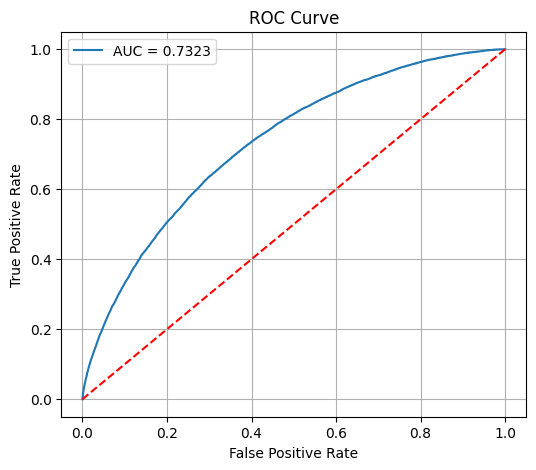

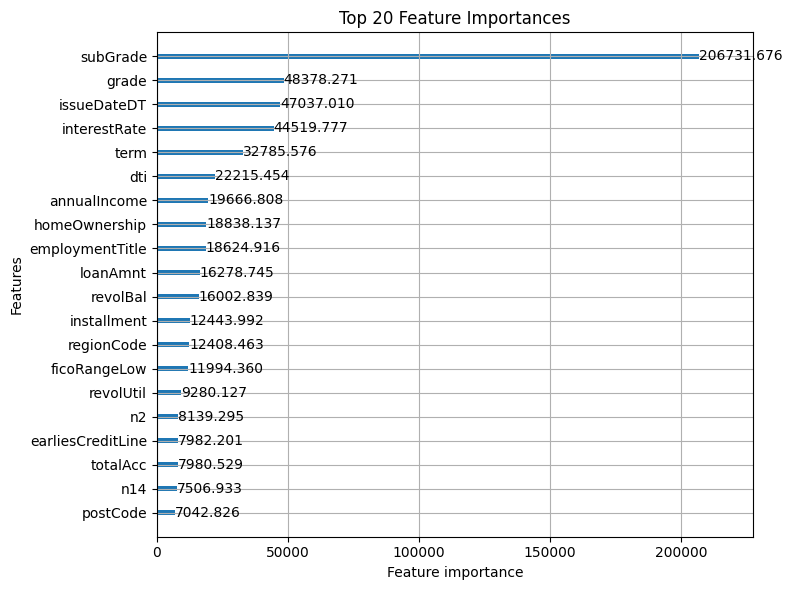

In [33]:
model, best_params = bayesian_lgb_optimizer(X_os, y_os)

🔍 Starting Bayesian Optimization...
|   iter    |  target   | baggin... | baggin... | featur... | max_depth | min_ch... | min_da... | min_sp... | num_le... | reg_alpha | reg_la... |
-------------------------------------------------------------------------------------------------------------------------------------------------
| 1         | 0.7079    | 0.7498    | 95.12     | 0.8928    | 13.18     | 1.561     | 24.04     | 0.05808   | 131.3     | 6.011     | 7.081     |
| 2         | 0.7079    | 0.6082    | 97.02     | 0.933     | 6.61      | 1.819     | 26.51     | 0.3042    | 83.47     | 4.319     | 2.912     |
| 3         | 0.709     | 0.8447    | 14.81     | 0.7169    | 9.228     | 4.561     | 80.67     | 0.1997    | 81.99     | 5.924     | 0.4645    |
| 4         | 0.7086    | 0.843     | 17.88     | 0.626     | 19.13     | 9.656     | 82.76     | 0.3046    | 23.67     | 6.842     | 4.402     |
| 5         | 0.7086    | 0.6488    | 50.02     | 0.6138    | 18.46     | 2.589     | 69

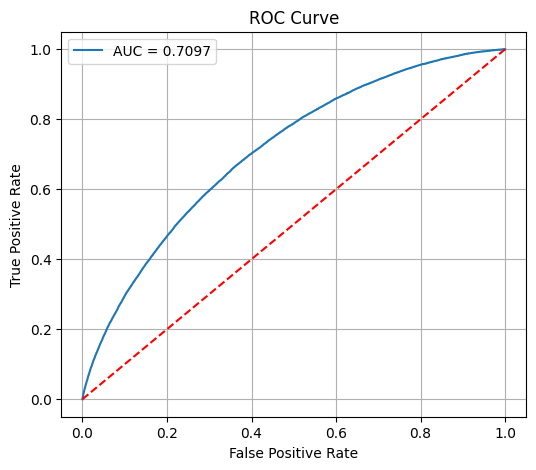

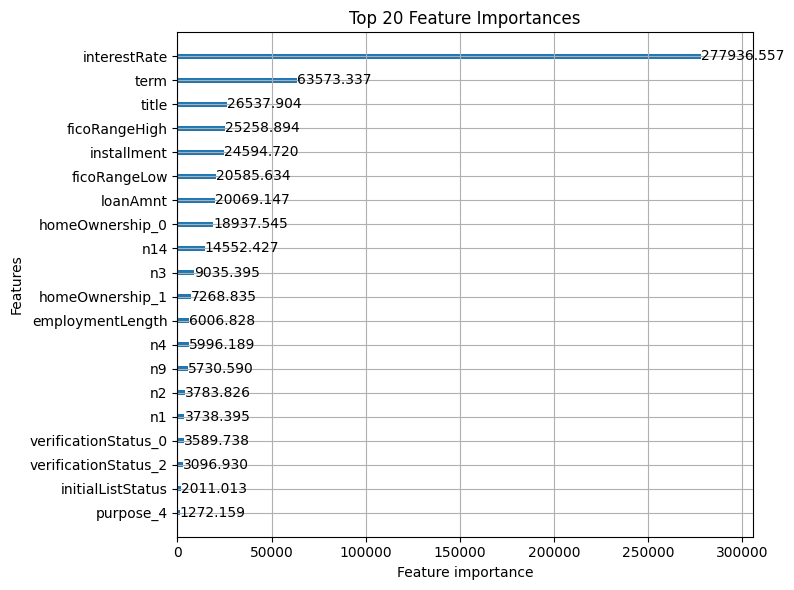

In [34]:
model, best_params = bayesian_lgb_optimizer(X_cs, y_cs)

In [44]:
import optuna
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import numpy as np

def catboost_objective_all(trial):
    params = {
        'loss_function': 'Logloss',
        'eval_metric': 'AUC',
        'random_seed': 42,
        'verbose': 0,
        'depth': trial.suggest_int('depth', 3, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1.0, 10.0),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'iterations': trial.suggest_int('iterations', 500, 3000),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'rsm': trial.suggest_float('rsm', 0.5, 1.0)
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    aucs = []

    for train_idx, valid_idx in cv.split(X_os, y_os):
        X_train, X_valid = X_os.iloc[train_idx], X_os.iloc[valid_idx]
        y_train, y_valid = y_os.iloc[train_idx], y_os.iloc[valid_idx]

        train_pool = Pool(X_train, y_train)
        valid_pool = Pool(X_valid, y_valid)

        model = CatBoostClassifier(**params)
        model.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=200, use_best_model=True)

        preds = model.predict_proba(X_valid)[:, 1]
        auc = roc_auc_score(y_valid, preds)
        aucs.append(auc)

    return np.mean(aucs)

# 执行调参
study_cat_all = optuna.create_study(direction='maximize')
study_cat_all.optimize(catboost_objective_all, n_trials=50, n_jobs=5)

print("✅ Best Parameters:")
print(study_cat_all.best_params)
print("✅ Best AUC:")
print(study_cat_all.best_value)

[I 2025-05-14 20:31:34,883] A new study created in memory with name: no-name-9bb7a109-833f-48bf-b175-4664b9b627cb
[I 2025-05-14 20:35:20,835] Trial 0 finished with value: 0.7316773940673763 and parameters: {'depth': 10, 'l2_leaf_reg': 9.331059161410876, 'min_data_in_leaf': 28, 'learning_rate': 0.042677570326182794, 'iterations': 2827, 'subsample': 0.6544748441281788, 'rsm': 0.517472109247225}. Best is trial 0 with value: 0.7316773940673763.
[I 2025-05-14 20:39:36,904] Trial 1 finished with value: 0.7303993048336676 and parameters: {'depth': 9, 'l2_leaf_reg': 2.9120822961265405, 'min_data_in_leaf': 71, 'learning_rate': 0.01472117409769442, 'iterations': 1371, 'subsample': 0.855744112348463, 'rsm': 0.6463736865364773}. Best is trial 0 with value: 0.7316773940673763.
[I 2025-05-14 20:43:11,903] Trial 2 finished with value: 0.7326064196036878 and parameters: {'depth': 7, 'l2_leaf_reg': 7.899728205872676, 'min_data_in_leaf': 20, 'learning_rate': 0.03452795023762319, 'iterations': 1686, 'sub

✅ 最佳参数:
{'depth': 7, 'l2_leaf_reg': 6.238475099689444, 'min_data_in_leaf': 29, 'learning_rate': 0.02626367266035725, 'iterations': 2862, 'subsample': 0.7756788204117906, 'rsm': 0.563378605916552}
✅ 最佳AUC:
0.7331792792939333


In [8]:
import optuna
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score
import numpy as np # Make sure numpy is imported


# --- Stage 1: Tune tree structure parameters ---
print("--- Starting Stage 1: Tuning tree structure parameters (depth, l2_leaf_reg, min_data_in_leaf) ---")

def catboost_objective_stage1(trial):
    # Define parameters to be tuned in this stage
    params = {
        'loss_function': 'Logloss',
        'eval_metric': 'AUC',
        'random_seed': 42,
        'verbose': 0,  # Suppress CatBoost output during tuning
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-2, 10.0, log=True),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 20)
        # 'iterations' and 'learning_rate' are fixed or set to sensible defaults for this stage
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    aucs = []

    for train_idx, valid_idx in cv.split(X_os, y_os):
        X_train, X_valid = X_os.iloc[train_idx], X_os.iloc[valid_idx]
        y_train, y_valid = y_os.iloc[train_idx], y_os.iloc[valid_idx]

        train_pool = Pool(X_train, y_train)
        valid_pool = Pool(X_valid, y_valid)

        # Using a fixed number of iterations and early stopping for faster evaluation in this stage
        model = CatBoostClassifier(**params, iterations=500, early_stopping_rounds=200)
        model.fit(train_pool, eval_set=valid_pool, use_best_model=True)
        
        preds = model.predict_proba(X_valid)[:, 1]
        auc = roc_auc_score(y_valid, preds)
        aucs.append(auc)

    return np.mean(aucs)

# Create an Optuna study object and optimize
study_cat1 = optuna.create_study(direction='maximize')
# Note: n_jobs=50 is very high, ensure your machine has enough cores or adjust accordingly.
study_cat1.optimize(catboost_objective_stage1, n_trials=50, n_jobs=5, show_progress_bar=True)

print("\n--- Stage 1 Results ---")
print("✅ Best parameters from Stage 1:")
print(study_cat1.best_params)
print("✅ Best AUC from Stage 1:")
print(study_cat1.best_value)

[I 2025-05-15 17:45:31,267] A new study created in memory with name: no-name-06a86a58-a9db-4ad1-a04e-63424fde7ea8


--- Starting Stage 1: Tuning tree structure parameters (depth, l2_leaf_reg, min_data_in_leaf) ---


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-05-15 17:48:35,422] Trial 0 finished with value: 0.7246639881205373 and parameters: {'depth': 4, 'l2_leaf_reg': 1.9588988171389898, 'min_data_in_leaf': 10}. Best is trial 0 with value: 0.7246639881205373.
[I 2025-05-15 17:48:40,773] Trial 1 finished with value: 0.7246565875745328 and parameters: {'depth': 4, 'l2_leaf_reg': 0.27411652429850525, 'min_data_in_leaf': 7}. Best is trial 0 with value: 0.7246639881205373.
[I 2025-05-15 17:48:40,789] Trial 2 finished with value: 0.7246911676727584 and parameters: {'depth': 4, 'l2_leaf_reg': 0.2189374985258161, 'min_data_in_leaf': 17}. Best is trial 2 with value: 0.7246911676727584.
[I 2025-05-15 17:48:40,813] Trial 4 finished with value: 0.7274885220444203 and parameters: {'depth': 6, 'l2_leaf_reg': 0.01005100742183429, 'min_data_in_leaf': 4}. Best is trial 4 with value: 0.7274885220444203.
[I 2025-05-15 17:48:40,832] Trial 3 finished with value: 0.7274146376048061 and parameters: {'depth': 6, 'l2_leaf_reg': 0.5519690068155303, 'min_dat

In [10]:
# --- Stage 2: Tune learning rate and iterations ---
print("\n--- Starting Stage 2: Tuning learning_rate and iterations ---")

def catboost_objective_stage2(trial):
    # Use the best parameters from Stage 1 as a base
    base_params = study_cat1.best_params.copy()

    # Update with parameters to be tuned in this stage
    base_params.update({
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'iterations': trial.suggest_int('iterations', 100, 10000), # Note: early_stopping_rounds will effectively cap this
        'loss_function': 'Logloss',      # Fixed
        'eval_metric': 'AUC',            # Fixed
        'random_seed': 42,               # Fixed
        'verbose': 0                     # Fixed
    })

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    aucs = []

    for train_idx, valid_idx in cv.split(X_os, y_os):
        X_train, X_valid = X_os.iloc[train_idx], X_os.iloc[valid_idx]
        y_train, y_valid = y_os.iloc[train_idx], y_os.iloc[valid_idx]

        train_pool = Pool(X_train, y_train)
        valid_pool = Pool(X_valid, y_valid)

        # early_stopping_rounds is important here, especially if 'iterations' can be large
        model = CatBoostClassifier(**base_params) # iterations is now from base_params
        model.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=200, use_best_model=True)
        
        preds = model.predict_proba(X_valid)[:, 1]
        auc = roc_auc_score(y_valid, preds)
        aucs.append(auc)

    return np.mean(aucs)

# Create an Optuna study object and optimize
study_cat2 = optuna.create_study(direction='maximize')
# Note: n_jobs=50 is very high, ensure your machine has enough cores or adjust accordingly.
study_cat2.optimize(catboost_objective_stage2, n_trials=50, n_jobs=5, show_progress_bar=True)

print("\n--- Stage 2 Results ---")
print("✅ Best parameters from Stage 2 (includes Stage 1 best params):")
print(study_cat2.best_params)
print("✅ Best AUC from Stage 2:")
print(study_cat2.best_value)

[I 2025-05-16 11:16:06,146] A new study created in memory with name: no-name-f84f687e-e6f1-44bf-a333-4bfb763147a6



--- Starting Stage 2: Tuning learning_rate and iterations ---


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-05-16 11:24:43,326] Trial 2 finished with value: 0.7279939380023641 and parameters: {'learning_rate': 0.19094176229826773, 'iterations': 5185}. Best is trial 2 with value: 0.7279939380023641.
[I 2025-05-16 11:24:54,716] Trial 3 finished with value: 0.7279987025986399 and parameters: {'learning_rate': 0.19835163484493343, 'iterations': 1304}. Best is trial 3 with value: 0.7279987025986399.
[I 2025-05-16 11:26:05,197] Trial 1 finished with value: 0.7290710566710181 and parameters: {'learning_rate': 0.14159106746473316, 'iterations': 2911}. Best is trial 1 with value: 0.7290710566710181.
[I 2025-05-16 11:30:59,852] Trial 0 finished with value: 0.7307573232345248 and parameters: {'learning_rate': 0.08647228538948484, 'iterations': 1214}. Best is trial 0 with value: 0.7307573232345248.
[I 2025-05-16 11:32:42,056] Trial 6 finished with value: 0.7282348464608551 and parameters: {'learning_rate': 0.18917366510931446, 'iterations': 867}. Best is trial 0 with value: 0.7307573232345248.
[

In [15]:
# 组合 Stage 1 和 Stage 2 的最佳参数
combined_params_after_stage2 = study_cat1.best_params.copy()
combined_params_after_stage2.update(study_cat2.best_params)
print("\n--- Combined parameters after Stage 2 ---")
print(combined_params_after_stage2) # 这应该包含 depth, l2_leaf_reg, min_data_in_leaf, learning_rate, iterations


--- Combined parameters after Stage 2 ---
{'depth': 10, 'l2_leaf_reg': 5.723627043752613, 'min_data_in_leaf': 17, 'learning_rate': 0.010058801624786218, 'iterations': 6712}


In [17]:
# --- Stage 3: Tune subsampling parameters ---
print("\n--- Starting Stage 3: Tuning subsample and rsm (colsample_bylevel) ---")

# Use the best parameters from Stage 2 as a base
base_params_stage3 = combined_params_after_stage2.copy() # Renamed to avoid confusion with internal 'base_params'

def catboost_objective_stage3(trial):
    params = base_params_stage3.copy()
    
    # Add parameters to be tuned in this stage
    params.update({
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),       # Row subsampling
        'rsm': trial.suggest_float('rsm', 0.5, 1.0),                   # Column subsampling by level (colsample_bylevel)
        'loss_function': 'Logloss',   # Usually fixed based on problem
        'eval_metric': 'AUC',         # Usually fixed based on problem
        'random_seed': 42,
        'verbose': 0
        # iterations and learning_rate are taken from base_params_stage3 (best of Stage 2)
        # early_stopping_rounds is not explicitly used with cross_val_score here in the same way,
        # CatBoost will use its internal logic for early stopping if iterations is high enough
        # and an eval_set is internally created or if it's set and no eval_set is provided in fit.
        # If you want explicit early stopping per fold here, you'd need a manual loop like in stage 1 & 2.
    })
    
    model = CatBoostClassifier(**params)
    
    # 5-fold cross-validation using scikit-learn's cross_val_score
    cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # Renamed for clarity
    # n_jobs=-1 in cross_val_score will use all available cores for fitting models for different folds
    # This is different from Optuna's n_jobs, which parallelizes trials.
    scores = cross_val_score(model, X_os, y_os, cv=cv_strategy, scoring='roc_auc', n_jobs=-1) 
    
    return scores.mean()

# Create an Optuna study object and optimize
study_cat3 = optuna.create_study(direction='maximize')
# Note: n_jobs=50 is very high, ensure your machine has enough cores or adjust accordingly for Optuna trials.
study_cat3.optimize(catboost_objective_stage3, n_trials=50, n_jobs=8, show_progress_bar=True)

# View results
print("\n--- Stage 3 Results ---")
print("✅ Best parameters from Stage 3 (includes best from Stage 1 & 2):")
print(study_cat3.best_params) # These are only 'subsample' and 'rsm'
print("✅ Final combined best parameters after Stage 3:")
final_best_params = base_params_stage3.copy()
final_best_params.update(study_cat3.best_params)
print(final_best_params)
print("✅ Best AUC from Stage 3:")
print(study_cat3.best_value)


[I 2025-05-20 10:59:19,738] A new study created in memory with name: no-name-7c964269-d4f4-4984-ba40-99db1a723259



--- Starting Stage 3: Tuning subsample and rsm (colsample_bylevel) ---


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-05-20 11:30:13,738] Trial 7 finished with value: 0.7333729663092543 and parameters: {'subsample': 0.5042717034689834, 'rsm': 0.7585242827038292}. Best is trial 7 with value: 0.7333729663092543.
[I 2025-05-20 11:32:06,690] Trial 2 finished with value: 0.7334241784769135 and parameters: {'subsample': 0.7147566800314239, 'rsm': 0.7235105569470726}. Best is trial 2 with value: 0.7334241784769135.
[I 2025-05-20 12:05:55,875] Trial 0 finished with value: 0.7334347900155579 and parameters: {'subsample': 0.6389603114751142, 'rsm': 0.6118798005907387}. Best is trial 0 with value: 0.7334347900155579.
[I 2025-05-20 12:09:05,568] Trial 1 finished with value: 0.7333159344736597 and parameters: {'subsample': 0.8128572157525226, 'rsm': 0.5319436424761365}. Best is trial 0 with value: 0.7334347900155579.
[I 2025-05-20 12:14:18,283] Trial 3 finished with value: 0.7331277980872632 and parameters: {'subsample': 0.9143578165165667, 'rsm': 0.9593658533398994}. Best is trial 0 with value: 0.73343479

In [18]:
final_best_params

{'depth': 10,
 'l2_leaf_reg': 5.723627043752613,
 'min_data_in_leaf': 17,
 'learning_rate': 0.010058801624786218,
 'iterations': 6712,
 'subsample': 0.5910150119329233,
 'rsm': 0.9949077181728889}

In [19]:
final_catboost_params = final_best_params.copy()

In [20]:
final_catboost_params['loss_function'] = 'Logloss'
final_catboost_params['eval_metric'] = 'AUC'
final_catboost_params['random_seed'] = 42
final_catboost_params['early_stopping_rounds'] = 200
final_catboost_params['verbose'] = 200

In [21]:
from sklearn.model_selection import train_test_split

X_train_final, X_val_final, y_train_final, y_val_final = train_test_split(
    X_os,
    y_os,
    test_size=0.1,
    random_state=42,
    stratify=y_os
)
print(f"Final training set size: {X_train_final.shape[0]}")
print(f"Finale validation set size: {X_val_final.shape[0]}")

Final training set size: 574103
Finale validation set size: 63790


In [23]:
final_cat_model = CatBoostClassifier(**final_catboost_params)

final_cat_model.fit(
    X_train_final, y_train_final,
    eval_set=(X_val_final, y_val_final),
    use_best_model=True
)

print(f"Number of trees in the final model: {final_model.tree_count_}")
if 'early_stopping_rounds' in final_catboost_params:
    print(f"Best iteration found: {final_model.get_best_iteration()}")
    best_score_dict = final_model.get_best_score()
    if best_score_dict and 'validation' in best_score_dict and 'AUC' in best_score_dict['validation']:
         print(f"Best AUC on internal eval set: {best_score_dict['validation']['AUC']:.4f}")


model_filename = "final_catboost_model.cbm"
final_model.save_model(model_filename)
print(f"\nFinal CatBoost model saved to: {model_filename}")

0:	test: 0.6831309	best: 0.6831309 (0)	total: 21.1ms	remaining: 2m 21s
200:	test: 0.7182047	best: 0.7182047 (200)	total: 7.26s	remaining: 3m 55s
400:	test: 0.7231435	best: 0.7231435 (400)	total: 14.7s	remaining: 3m 51s
600:	test: 0.7253156	best: 0.7253156 (600)	total: 22.1s	remaining: 3m 45s
800:	test: 0.7267096	best: 0.7267096 (800)	total: 29.7s	remaining: 3m 39s
1000:	test: 0.7277902	best: 0.7277902 (1000)	total: 37.2s	remaining: 3m 32s
1200:	test: 0.7286408	best: 0.7286408 (1200)	total: 44.7s	remaining: 3m 25s
1400:	test: 0.7294325	best: 0.7294325 (1400)	total: 52.3s	remaining: 3m 18s
1600:	test: 0.7301421	best: 0.7301421 (1600)	total: 59.8s	remaining: 3m 10s
1800:	test: 0.7307466	best: 0.7307466 (1800)	total: 1m 7s	remaining: 3m 3s
2000:	test: 0.7311666	best: 0.7311666 (2000)	total: 1m 14s	remaining: 2m 56s
2200:	test: 0.7314669	best: 0.7314730 (2197)	total: 1m 22s	remaining: 2m 48s
2400:	test: 0.7317601	best: 0.7317601 (2400)	total: 1m 29s	remaining: 2m 41s
2600:	test: 0.7319805	b

In [24]:
cat_preds_proba = final_cat_model.predict_proba(test_os)[:, 1]
cat_preds_proba

array([0.06242694, 0.34097979, 0.57373119, ..., 0.12556377, 0.23872086,
       0.02546471])

In [32]:
import pickle
try:
    with open("final_xgboost_model.pkl", "rb") as file:
        final_xgb_model = pickle.load(file)
        print("XGBoost model loaded successfully")
except Exception as e:
    print(f"An error occurred while loading: {e}")

XGBoost model loaded successfully


In [33]:
xgb_preds_proba = final_xgb_model.predict_proba(test_os)[:, 1]
xgb_preds_proba

array([0.07499005, 0.31878033, 0.580858  , ..., 0.2387279 , 0.24399339,
       0.02313996], dtype=float32)

In [34]:
simple_avg_preds = (cat_preds_proba + xgb_preds_proba) / 2
simple_avg_preds

array([0.0687085 , 0.32988006, 0.57729459, ..., 0.18214583, 0.24135712,
       0.02430233])

In [35]:
testA = pd.read_csv('testA.csv')
test_ids = testA['id']

submission = pd.DataFrame({
    'id': test_ids,
    'isDefault': simple_avg_preds
})

submission.to_csv('submit.csv', index=False)